##### This notebook simulates how correlation changes DDM predicitons depending on the degree to which the correlation is underestimated.


Produces Figure 5b, Fig 5-Sup 1b.

Normative evidence weighting and accumulation in correlated environments. Tardiff et al. (2025).

Updated to reflect new models in eLife revision.

Nathan Tardiff
01/15/25

### parameter notes
- Parameter values were set as medium parameter values across subjects in the 0.6 correlation condition
- Rscale of 0.75 was chosen b/c it is a "round" number that produces a correlation close to the average correlation found in the emprical data
    - Recall that r is scaled on fisher scale, so rscale of 0.75 produces a corr of 0.48, as compared to the median negative fit corr of -0.47 and the median positive fit corr of 0.44.
- Generative means were chosen to match the generative means for the median psychophysical threshold in the empirical data.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib import rc as rcmat
import pandas as pd
import pickle
from os import path
import copy
from datetime import date
from ddm import Sample
from ddm.functions import fit_adjust_model, display_model, solve_partial_conditions
import ddm_corr
import models_corr
from ddm import set_N_cpus

%config InlineBackend.figure_formats = ['svg']

In [2]:
#global style settings
rcmat('font',**{'family':'sans-serif','sans-serif':['Arial']})

plt.rcParams['font.size'] = 10.0
plt.rcParams["figure.labelsize"] = 11.0 #supxlabel/supylabel
plt.rcParams["figure.titlesize"] = 12.0 #title/suptitle
plt.rcParams['legend.fontsize'] = 8.0
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['mathtext.fontset'] = 'custom' #so uses same font as normal text for math/symbols

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

cm = 1/2.54  # centimeters in inches

In [3]:
set_N_cpus(4)
fit_dir = './fits'
fig_dir = './Manuscript/Figure set draft/figs_raw'
samp_dir = './samps'

#set some parameters for fitting

nsamp = 64 #how many samples per r/mu condition
nrun = 10 # how many runs per rscale condition?

#base conditions, which we will manipulate w/ a scale factor
#these are mu values from a subject with median threshold from 0.6 correlation group

# rconds = {
#     -0.6: np.array([0.01214, 0.03035]),
#     0.0: np.array([0.01919, 0.04799]),
#     0.6: np.array([0.02428, 0.06070]),
#     }


mu0 = np.array([0.01919, 0.04799])
rhos0 = np.array([-0.6,0.,0.6])

rconds = {r:mu0*np.sqrt(1+r) for r in rhos0}


#for this we do want the negative mus
rconds = {k:np.sort(np.append(v,-v)) for k,v in rconds.items()}

#set simulation correlation scale factors
rscale = np.array([0,0.25,.75,1])
print(rscale)

#set simulation correlation deviates
r_deviates = np.array([0]) #np.array([-0.5,-0.2,0,0.2,0.5]) #np.array([-0.2])
print(r_deviates)

#generate sds used in the simulated model
#in actual fits, we don't set an SD beyond the corr manipulation, so not doing so here....
gSigma = 1 #np.sqrt(2)/2 #this conveniently ends up setting the sd for r=0 to 1
rs = np.round(np.array(list(rconds.keys())),1)

#this scale is generative sd for sum of pair distribution
#scale = 1/(gSigma*np.sqrt(2*(1+rs)))
#sds = np.round(gSigma*np.sqrt(2*(1+rs)),8)
#in this sim wer are just going to scale by r, assuming sd is 1, like we did in actual fits
sds = np.round(np.sqrt(1+rs),8)

base_B = 1.75
base_drift = 16.5
B_names = ['Bn','B0','Bp']

[0.   0.25 0.75 1.  ]
[0]


In [4]:
#cosmetics (may need to change if everything is too overlapping)
cmap = mpl.colormaps['RdBu'](np.linspace(0,1,20))
r_colors = dict(zip([-1.0,0.0,1.0], [cmap[0],(0.5,0.5,0.5,1.0),cmap[-1]]))

#we'll use this
idx = pd.IndexSlicerscale_colors = dict(zip(rscale,mcolors.TABLEAU_COLORS.keys()))

rdev_colors = dict(zip(r_deviates,mcolors.TABLEAU_COLORS.keys()))

In [5]:
#helper function for figure sizing
#from:https://stackoverflow.com/questions/44970010/axes-class-set-explicitly-size-width-height-of-axes-in-given-units

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    
def plot_psycho_chrono_ave(psychodf,chronodf,r_colors=r_colors,mod_suffix=[''],mod_line=['-'],alpha=1,RT_err=True,
                           ax=None,ax_labels=True,plot_data=True,plot_pred=True):
    if isinstance(mod_suffix,str):
        mod_suffix = [mod_suffix]
    if isinstance(mod_line,str):
        mod_line = [mod_line]        
    multi_cond = (list(r_colors.keys())==[-1.0,0.0,1.0])
    
    if ax is None:
        fig,ax = plt.subplots(nrows=1,ncols=2+RT_err)
    else:
        fig = None
                
    for (r,dd),(rr,ddc) in zip(psychodf.groupby('rho'),chronodf.groupby('rho')):
        #plot psycho
        assert r==rr
        r_col = np.sign(r) if multi_cond else r
        dd.index=dd.index.droplevel(['rho'])
        if plot_data:
            ax[0].errorbar(dd.index,dd['response']['mean'],dd['response']['sem'],
                            marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12,elinewidth=2,alpha=alpha)
        #ax[0].plot(dd.index,dd['pred_response']['mean'],linestyle='-',color=r_colors[r_col])
        if plot_pred:
            for m,l in zip(mod_suffix,mod_line):
                ax[0].plot(dd['pred_response' + m]['mean'],linestyle=l,color=r_colors[r_col],alpha=alpha)

        set_size(12,4,ax[0])
        if plot_data:
            ax[0].legend()
        if ax_labels:
            ax[0].set_xlabel('SNR')
            ax[0].set_ylabel('proportion choose right')

        #plot chrono
        ddc.index=ddc.index.droplevel(['rho'])
        chrono_corr = ddc.xs(1.0,level='correct')
        chrono_err = ddc.xs(0.0,level='correct')
        
        if plot_data:
            ax[1].errorbar(chrono_corr.index,chrono_corr['RT']['mean'],chrono_corr['RT']['sem'],
                           marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12,elinewidth=2,alpha=alpha)
        
        if plot_pred:
            for m,l in zip(mod_suffix,mod_line):
                ax[1].plot(chrono_corr['mean_RT_corr'+m]['mean'],linestyle=l,color=r_colors[r_col],alpha=alpha)
            
        set_size(12,4,ax[1])
        if ax_labels:
            ax[1].set_xlabel('SNR')
            ax[1].set_ylabel('mean RT (correct trials)')
        
        if RT_err:
            if plot_data:
                ax[2].errorbar(chrono_err.index,chrono_err['RT']['mean'],chrono_err['RT']['sem'],
                               marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12,elinewidth=2)
            
            if plot_pred:
                for m,l in zip(mod_suffix,mod_line):
                    ax[2].plot(chrono_err['mean_RT_err' + m]['mean'],linestyle=l,color=r_colors[r_col],alpha=alpha)
            
            if ax_labels:
                ax[2].set_xlabel('SNR')
                ax[2].set_ylabel('mean RT (error trials)')
            set_size(12,4,ax[2])
    
    return ax if fig is None else fig,ax

In [6]:
#are these correlation combos reasonable 
for this_scale in rscale:
    for this_devz in r_deviates:
        print(models_corr.fishezr(this_scale*models_corr.fisherz(rs) + models_corr.fisherz(this_devz)))

[0. 0. 0.]
[-0.17157288  0.          0.17157288]
[-0.47759225  0.          0.47759225]
[-0.6  0.   0.6]


## Bound model

In [7]:
#set up model we will use to sample for subsequent fitting

samp_model = copy.deepcopy(models_corr.this_ddm)

#set the noise term
ddm_corr.set_model_params(samp_model,'Noise',noisen=sds[0],noise0=sds[1],noisep=sds[2])

#set drift
ddm_corr.set_model_params(samp_model,'Drift',driftSNRn=base_drift,driftSNR0=base_drift,driftSNRp=base_drift)

#set overlay (a bit janky here)
ol=samp_model.get_dependence('overlay')
ol.overlays[0].nondectime=0.285
ol.overlays[1].umixturecoef=0.007

samp_model.T_dur = 35

drift = samp_model.get_dependence('Drift')
assert drift.required_parameters==['driftSNRn', 'driftSNR0', 'driftSNRp'], 'Unexpected drift params!'

samp_model

Model(name='sampling model', drift=DriftSNRCorr(driftSNRn=16.5, driftSNR0=16.5, driftSNRp=16.5), noise=NoiseCorr(noisep=1.26491106, noise0=1.0, noisen=0.63245553), bound=BoundCorr(Bn=1.7, B0=1.7, Bp=1.7), IC=ICPointSourceCenter(), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=0.285), OverlayUniformMixture(umixturecoef=0.007)]), dx=0.005, dt=0.005, T_dur=35)

In [8]:
#now let's simulate. Amount of bound adjustment is controlled by rscale and rdev
do_samp = False
smooth_pred = True

if do_samp:
#     samp_data_star = []
    preds_star = []
    bound_adj_star = []
    if smooth_pred:
        preds_star_smooth = []
    for this_scale in rscale:
        for this_devz in r_deviates:
            #set bound scale adjustment
            print(this_scale)
            print(this_devz)
            this_rs = models_corr.fishezr(this_scale*models_corr.fisherz(rs) + models_corr.fisherz(this_devz)) # add on z-scale then backxform
            print(this_rs)
            Bs = base_B*np.sqrt(1+this_rs)
            ddm_corr.set_model_params(samp_model,'Bound',**dict(zip(B_names,Bs)))
            print(samp_model)
            print(Bs/sds)

            this_drift = [getattr(drift,d) for d in drift.required_parameters]
            #save bound adjustment characteristics
            this_bound_adj_star = pd.DataFrame({'rho': rs,'B':Bs,'sd':sds,'drift':this_drift})
            this_bound_adj_star['rscale'] = this_scale
            this_bound_adj_star['rdev'] = this_devz
            bound_adj_star.append(this_bound_adj_star)

            #generate expected predictions
            this_pred = ddm_corr.gen_predict(rconds,samp_model,forced=True,err_RT=True,undec=True)
            assert this_pred['mean_undec'].max() < 0.01, "Too many undecided trials!"
            this_pred['rscale'] = this_scale
            this_pred['rdev'] = this_devz
            preds_star.append(this_pred)
            
            #generate smooth predictions
            if smooth_pred:
                rconds_smooth = {k:np.linspace(v[0],v[-1],100) for k,v in rconds.items()}
                this_pred_smooth = ddm_corr.gen_predict(rconds_smooth,samp_model,forced=True,err_RT=True,undec=True)
                assert this_pred_smooth['mean_undec'].max() < 0.01, "Too many undecided trials!"
                this_pred_smooth['rscale'] = this_scale
                this_pred_smooth['rdev'] = this_devz
                preds_star_smooth.append(this_pred_smooth)

#             #generate samples for each run
#             for n in range(0,nrun):
#                 this_samp = ddm_corr.gen_samples(rconds,samp_model,nsamp)
#                 this_samp['rscale'] = this_scale
#                 this_samp['rdev'] = this_devz
#                 this_samp['run'] = n
#                 samp_data_star.append(this_samp)       

                
    #stitch conditions/runs together
    bound_adj_star = pd.concat(bound_adj_star,ignore_index=True)
    bound_adj_star['B_sd'] = bound_adj_star.B/bound_adj_star.sd
    bound_adj_star['drift_B'] = (bound_adj_star.drift/bound_adj_star.B) #drift bound ratio should be constant only for rscale == 0

    preds_star = pd.concat(preds_star,ignore_index=True)
    if smooth_pred:
        preds_star_smooth = pd.concat(preds_star_smooth,ignore_index=True)
#     samp_data_star = pd.concat(samp_data_star,ignore_index=True)

    #save
    out_suffix = '_%s.csv' % date.today()
    bound_adj_star.to_csv(path.join(samp_dir,'bound_adj_starCL_fig4'+out_suffix),index=False)
    preds_star.to_csv(path.join(samp_dir,'preds_starCL_fig4'+out_suffix),index=False)
    if smooth_pred:
        preds_star_smooth.to_csv(path.join(samp_dir,'preds_star_smoothCL_fig4'+out_suffix),index=False)
#     samp_data_star.to_csv(path.join(samp_dir,'samp_data_starCL_fig4'+out_suffix),index=False)
else:
    #load already generated simulations
    bound_adj_star = pd.read_csv(path.join(samp_dir,'bound_adj_starCL_fig4_2025-01-15.csv'))
    preds_star = pd.read_csv(path.join(samp_dir,'preds_starCL_fig4_2025-01-15.csv'))
    if smooth_pred:
        preds_star_smooth = pd.read_csv(path.join(samp_dir,'preds_star_smoothCL_fig4_2025-01-15.csv'))
#     samp_data_star = pd.read_csv(path.join(samp_dir,'samp_data_starCL_fig4_2023-12-08.csv'))
    
print(bound_adj_star)
print(bound_adj_star.shape)

print(preds_star.head())
print(preds_star.shape)

if smooth_pred:
    print(preds_star_smooth.head())
    print(preds_star_smooth.shape)

# print(samp_data_star.head())
# print(samp_data_star.shape)

    rho         B        sd  drift  rscale  rdev      B_sd    drift_B
0  -0.6  1.750000  0.632456   16.5    0.00     0  2.766993   9.428571
1   0.0  1.750000  1.000000   16.5    0.00     0  1.750000   9.428571
2   0.6  1.750000  1.264911   16.5    0.00     0  1.383496   9.428571
3  -0.6  1.592815  0.632456   16.5    0.25     0  2.518461  10.359022
4   0.0  1.750000  1.000000   16.5    0.25     0  1.750000   9.428571
5   0.6  1.894186  1.264911   16.5    0.25     0  1.497486   8.710864
6  -0.6  1.264861  0.632456   16.5    0.75     0  1.999921  13.044910
7   0.0  1.750000  1.000000   16.5    0.75     0  1.750000   9.428571
8   0.6  2.127234  1.264911   16.5    0.75     0  1.681726   7.756550
9  -0.6  1.106797  0.632456   16.5    1.00     0  1.750000  14.907880
10  0.0  1.750000  1.000000   16.5    1.00     0  1.750000   9.428571
11  0.6  2.213594  1.264911   16.5    1.00     0  1.750000   7.453940
(12, 8)
         mu  rho  mean_corr  mean_err  mean_RT_corr    mean_undec  \
0 -0.030352 -

### Plot predictions

In [9]:
preds_star_smooth = preds_star_smooth.merge(bound_adj_star.loc[:,['rho','rscale','rdev','sd']],on=['rho','rscale','rdev'])

In [10]:
#this is the LLR at the generative mean, 
#where here sd is the sd of the sum distribution for a given correlation assuming base sd (gSigma) is 1
#signed based on generative mean
preds_star_smooth['SNR'] = np.sign(preds_star_smooth['mu'])*((4*preds_star_smooth['mu']**2) / preds_star_smooth['sd']**2)
preds_star_smooth['SNR'] = preds_star_smooth['SNR'].round(4)

#code in terms of choice instead of correct for preds
preds_star_smooth['pred_response'] = preds_star_smooth['mean_corr']
preds_star_smooth.loc[preds_star_smooth.SNR<0,'pred_response'] = preds_star_smooth.loc[preds_star_smooth.SNR<0,'mean_err'] 

In [11]:
#very hacky to work w/ existing plotting function
preds_star_smooth_chrono_corr = preds_star_smooth.copy()
preds_star_smooth_chrono_corr['correct'] = 1. 

preds_star_smooth_chrono_err = preds_star_smooth.copy()
preds_star_smooth_chrono_err['correct'] = 0. 

preds_star_smooth_chrono = pd.concat([preds_star_smooth_chrono_corr,preds_star_smooth_chrono_err],ignore_index=True)

preds_star_smooth_psycho_ave = \
    preds_star_smooth[['rscale','rho','SNR','pred_response']].groupby(['rscale','rho','SNR']).agg(['mean'])
display(preds_star_smooth_psycho_ave.groupby('rscale').head())

preds_star_smooth_chrono_ave = \
    preds_star_smooth_chrono[['rscale','rho','SNR','correct','mean_RT_corr','mean_RT_err']].groupby(['rscale','rho','SNR','correct']).agg(['mean'])
display(preds_star_smooth_chrono_ave.groupby('rscale').head())

pred_response
                             mean
rscale rho  SNR                  
0.00   -0.6 -0.0092      0.015760
            -0.0088      0.016879
            -0.0085      0.018099
            -0.0081      0.019429
            -0.0078      0.020878
0.25   -0.6 -0.0092      0.021565
            -0.0088      0.023051
            -0.0085      0.024656
            -0.0081      0.026391
            -0.0078      0.028263
0.75   -0.6 -0.0092      0.043635
            -0.0088      0.046173
            -0.0085      0.048864
            -0.0081      0.051716
            -0.0078      0.054738
1.00   -0.6 -0.0092      0.061976
            -0.0088      0.065134
            -0.0085      0.068451
            -0.0081      0.071934
            -0.0078      0.075589

mean_RT_corr mean_RT_err
                                    mean        mean
rscale rho  SNR     correct                         
0.00   -0.6 -0.0092 0.0         3.737233    6.755568
                    1.0         3.737233    6.755568
            -0.0088 0.0         3.799295    6.601447
                    1.0         3.799295    6.601447
            -0.0085 0.0         3.863234    6.460946
0.25   -0.6 -0.0092 0.0         3.395450    5.642233
                    1.0         3.395450    5.642233
            -0.0088 0.0         3.448812    5.539488
                    1.0         3.448812    5.539488
            -0.0085 0.0         3.503627    5.447192
0.75   -0.6 -0.0092 0.0         2.656036    3.796522
                    1.0         2.656036    3.796522
            -0.0088 0.0         2.690743    3.762896
                    1.0         2.690743    3.762896
            -0.0085 0.0         2.726107    3.733660
1.00   -0.6 -0.0092 0.0         2.286741    3.092129
                    1.0         2.286741    3.092129
            -0.0088 0.0         2.312690    3.074776
                    1.0         2.312690    3.074776
            -0.0085 0.0         2.339000    3.059946

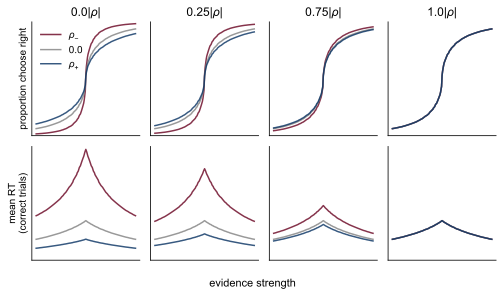

In [12]:
#now print version, predictions only SMOOTH 

fig,ax=plt.subplots(nrows=2,ncols=4,sharex=True)
#then plot best fit model only against data separately per corr cond
for axi,(rcp,dfp_r),(rcc,dfc_r) in zip(ax.T,preds_star_smooth_psycho_ave.groupby('rscale'),
                               preds_star_smooth_chrono_ave.groupby('rscale')):
    assert rcp==rcc
    #print(rcp)
    dfp_r.reset_index(level='rscale',drop=True,inplace=True)
    dfc_r.reset_index(level='rscale',drop=True,inplace=True)
    #display(dfp_r)
    #display(dfc_r)
    plot_psycho_chrono_ave(dfp_r,dfc_r,
                                   alpha=0.8,RT_err=False,ax=axi,ax_labels=False,plot_data=False)
    
    axi[0].set_xlim([-0.01,0.01])
    axi[0].set_ylim((0,1))
    axi[0].set_xticks([])
    ##axi[0].set_yticks([0,0.5,1])
    axi[0].set_yticks([])
    if rcp > 0 and rcp < 1:
        axi[0].set_title(r'%.2f$|\rho|$' % rcp)
    else:
        axi[0].set_title(r'%.1f$|\rho|$' % rcp)
    #axi[0].legend().set_visible(False)
    #axi[1].set_yticks([2,3])
    #axi[1].set_xticks([-1.0,0.0,1.0])
    axi[1].set_xlim([-0.01,0.01])
    axi[1].set_ylim([1,8.])
    axi[1].set_xticks([])
    axi[1].set_yticks([])
    
    axi[1].locator_params(nbins=3, axis='y')
    
    #if rcp > 0:
    axi[0].set_yticklabels([])
    axi[1].set_yticklabels([])
    
    #axi[1].set_ylim((1.75,4))
    ##set_size(6,3,axi[0])
    ##set_size(6,3,axi[1])
    
fig.supxlabel('evidence strength')
ax[0,0].set_ylabel('proportion choose right')
ax[0,0].legend(labels=(r'$\rho_{\minus}$','0.0',r'$\rho_{\plus}$'),
             frameon=False,fontsize=10,loc='upper left')
ax[1,0].set_ylabel('mean RT\n(correct trials)')
fig.set_figwidth(18*cm)
fig.set_figheight(21*cm/2)
fig.tight_layout()

fig.savefig(path.join(fig_dir,'fig5_ddm_preds_smooth_sk_%s.pdf' % date.today()))

## "full model"

In [13]:
#going to simplify this compared to above, which was culled from broader sims
#set up model we will use to sample for subsequent fitting

samp_model_full = copy.deepcopy(models_corr.this_ddm)

#set the noise term

#set drift
ddm_corr.set_model_params(samp_model_full,'Drift',driftSNRn=base_drift,driftSNR0=base_drift,driftSNRp=base_drift)

#set overlay (a bit janky here)
ol=samp_model_full.get_dependence('overlay')
ol.overlays[0].nondectime=0.285
ol.overlays[1].umixturecoef=0.007

drift = samp_model_full.get_dependence('Drift')
assert drift.required_parameters==['driftSNRn', 'driftSNR0', 'driftSNRp'], 'Unexpected drift params!'

samp_model_full.T_dur = 35

samp_model_full

Model(name='sampling model', drift=DriftSNRCorr(driftSNRn=16.5, driftSNR0=16.5, driftSNRp=16.5), noise=NoiseCorr(noisep=1.26491106, noise0=1.0, noisen=0.63245553), bound=BoundCorr(Bn=1.7, B0=1.7, Bp=1.7), IC=ICPointSourceCenter(), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=0.285), OverlayUniformMixture(umixturecoef=0.007)]), dx=0.005, dt=0.005, T_dur=35)

In [14]:
#now let's simulate. Amount of bound adjustment is controlled by rscale
do_pred = False
smooth_pred = True

if do_pred:
    preds_full = []
    bound_adj_full = []
    if smooth_pred:
        preds_full_smooth = []
    for this_scale in rscale:
        #set bound scale adjustment
        print(this_scale)
        this_rs = models_corr.fishezr(this_scale*models_corr.fisherz(rs)) # add on z-scale then backxform
        print(this_rs)
        Bs = base_B*(1+this_rs)/np.sqrt(1+rs)
        ddm_corr.set_model_params(samp_model_full,'Bound',**dict(zip(B_names,Bs)))
        
        #set noise based on same subjective sd
        this_sds = np.sqrt(1+this_rs)
        ddm_corr.set_model_params(samp_model_full,'Noise',noisen=this_sds[0],noise0=this_sds[1],noisep=this_sds[2])
        
        
        print(samp_model_full)
        print(Bs)
        print(sds)
        print(Bs/sds)

        this_drift = [getattr(drift,d) for d in drift.required_parameters]
        #save bound adjustment characteristics
        #using the true generative sd here for plotting purposes later
        this_bound_adj_full = pd.DataFrame({'rho': rs,'B':Bs,'sd':sds,'drift':this_drift})
        this_bound_adj_full['rscale'] = this_scale
        bound_adj_full.append(this_bound_adj_full)

        #generate expected predictions
        this_pred = ddm_corr.gen_predict(rconds,samp_model_full,method=None,forced=True,err_RT=True,undec=True)
        this_pred['rscale'] = this_scale
        assert this_pred['mean_undec'].max() < 0.01, "Too many undecided trials!"
        preds_full.append(this_pred)

        #generate smooth predictions
        if smooth_pred:
            rconds_smooth = {k:np.linspace(v[0],v[-1],100) for k,v in rconds.items()}
            this_pred_smooth = ddm_corr.gen_predict(rconds_smooth,samp_model_full,method=None,
                                                    forced=True,err_RT=True,undec=True)
            this_pred_smooth['rscale'] = this_scale
            assert this_pred_smooth['mean_undec'].max() < 0.01, "Too many undecided trials!"
            preds_full_smooth.append(this_pred_smooth)
                
    #stitch conditions/runs together
    bound_adj_full = pd.concat(bound_adj_full,ignore_index=True)
    bound_adj_full['B_sd'] = bound_adj_full.B/bound_adj_full.sd
    bound_adj_full['drift_B'] = (bound_adj_full.drift/bound_adj_full.B) #drift bound ratio should be constant only for rscale == 0

    preds_full = pd.concat(preds_full,ignore_index=True)
    if smooth_pred:
        preds_full_smooth = pd.concat(preds_full_smooth,ignore_index=True)

    #save
    out_suffix = '_%s.csv' % date.today()
    bound_adj_full.to_csv(path.join(samp_dir,'bound_adj_fullCL_fig4'+out_suffix),index=False)
    preds_full.to_csv(path.join(samp_dir,'preds_fullCL_fig4'+out_suffix),index=False)
    if smooth_pred:
        preds_full_smooth.to_csv(path.join(samp_dir,'preds_full_smoothCL_fig4'+out_suffix),index=False)
else:
    #load already generated simulations
    bound_adj_full = pd.read_csv(path.join(samp_dir,'bound_adj_fullCL_fig4_2025-01-15.csv'))
    preds_full = pd.read_csv(path.join(samp_dir,'preds_fullCL_fig4_2025-01-15.csv'))
    if smooth_pred:
        preds_full_smooth = pd.read_csv(path.join(samp_dir,'preds_full_smoothCL_fig4_2025-01-15.csv'))
    
print(bound_adj_full)
print(bound_adj_full.shape)

print(preds_full.head())
print(preds_full.shape)

if smooth_pred:
    print(preds_full_smooth.head())
    print(preds_full_smooth.shape)

    rho         B        sd  drift  rscale      B_sd    drift_B
0  -0.6  2.766993  0.632456   16.5    0.00  4.375000   5.963152
1   0.0  1.750000  1.000000   16.5    0.00  1.750000   9.428571
2   0.6  1.383496  1.264911   16.5    0.00  1.093750  11.926304
3  -0.6  2.292252  0.632456   16.5    0.25  3.624369   7.198161
4   0.0  1.750000  1.000000   16.5    0.25  1.750000   9.428571
5   0.6  1.620867  1.264911   16.5    0.25  1.281408  10.179737
6  -0.6  1.445499  0.632456   16.5    0.75  2.285534  11.414747
7   0.0  1.750000  1.000000   16.5    0.75  1.750000   9.428571
8   0.6  2.044244  1.264911   16.5    0.75  1.616117   8.071445
9  -0.6  1.106797  0.632456   16.5    1.00  1.750000  14.907880
10  0.0  1.750000  1.000000   16.5    1.00  1.750000   9.428571
11  0.6  2.213594  1.264911   16.5    1.00  1.750000   7.453940
(12, 7)
         mu  rho  mean_corr  mean_err  mean_RT_corr    mean_undec  \
0 -0.030352 -0.6   0.937992  0.062008      5.198062  7.263431e-05   
1 -0.012137 -0.6   0.7

In [15]:
display(preds_full)

,mu,rho,mean_corr,mean_err,mean_RT_corr,mean_undec,mean_RT_err,rscale
0,-0.030352,-0.6,0.937992,0.062008,5.198062,7.263431e-05,5.849325,0.00
1,-0.012137,-0.6,0.749428,0.250572,7.205522,2.427811e-03,7.302077,0.00
2,0.012137,-0.6,0.749428,0.250572,7.205522,2.427811e-03,7.302077,0.00
3,0.030352,-0.6,0.937992,0.062008,5.198062,7.263431e-05,5.849325,0.00
4,-0.047990,0.0,0.938024,0.061976,2.286741,2.397527e-11,3.092129,0.00
5,-0.019190,0.0,0.750035,0.249965,3.130666,1.935533e-07,3.265440,0.00
6,0.019190,0.0,0.750035,0.249965,3.130666,1.935533e-07,3.265440,0.00
7,0.047990,0.0,0.938024,0.061976,2.286741,2.397527e-11,3.092129,0.00
8,-0.060703,0.6,0.938024,0.061976,1.558308,0.000000e+00,2.402258,0.00
9,-0.024274,0.6,0.750035,0.249965,2.091804,1.543066e-11,2.236322,0.00


### Plot predictions

In [16]:
preds_full_smooth = preds_full_smooth.merge(bound_adj_full.loc[:,['rho','rscale','sd']],on=['rho','rscale'])

In [17]:
#this is the LLR at the generative mean, 
#where here sd is the sd of the sum distribution for a given correlation assuming base sd (gSigma) is 1
#signed based on generative mean
preds_full_smooth['SNR'] = np.sign(preds_full_smooth['mu'])*((4*preds_full_smooth['mu']**2) / preds_full_smooth['sd']**2)
preds_full_smooth['SNR'] = preds_full_smooth['SNR'].round(4)

#code in terms of choice instead of correct for preds
preds_full_smooth['pred_response'] = preds_full_smooth['mean_corr']
preds_full_smooth.loc[preds_full_smooth.SNR<0,'pred_response'] = preds_full_smooth.loc[preds_full_smooth.SNR<0,'mean_err']

In [18]:
#very hacky to work w/ existing plotting function
preds_full_smooth_chrono_corr = preds_full_smooth.copy()
preds_full_smooth_chrono_corr['correct'] = 1. 

preds_full_smooth_chrono_err = preds_full_smooth.copy()
preds_full_smooth_chrono_err['correct'] = 0. 

preds_full_smooth_chrono = pd.concat([preds_full_smooth_chrono_corr,preds_full_smooth_chrono_err],ignore_index=True)

preds_full_smooth_psycho_ave = \
    preds_full_smooth[['rscale','rho','SNR','pred_response']].groupby(['rscale','rho','SNR']).agg(['mean'])
display(preds_full_smooth_psycho_ave.groupby('rscale').head())

preds_full_smooth_chrono_ave = \
    preds_full_smooth_chrono[['rscale','rho','SNR','correct','mean_RT_corr','mean_RT_err']].groupby(['rscale','rho','SNR','correct']).agg(['mean'])
display(preds_full_smooth_chrono_ave.groupby('rscale').head())

pred_response
                             mean
rscale rho  SNR                  
0.00   -0.6 -0.0092      0.062008
            -0.0088      0.065172
            -0.0085      0.068495
            -0.0081      0.071985
            -0.0078      0.075647
0.25   -0.6 -0.0092      0.061980
            -0.0088      0.065139
            -0.0085      0.068457
            -0.0081      0.071941
            -0.0078      0.075597
0.75   -0.6 -0.0092      0.061976
            -0.0088      0.065134
            -0.0085      0.068451
            -0.0081      0.071934
            -0.0078      0.075589
1.00   -0.6 -0.0092      0.061976
            -0.0088      0.065134
            -0.0085      0.068451
            -0.0081      0.071934
            -0.0078      0.075589

mean_RT_corr mean_RT_err
                                    mean        mean
rscale rho  SNR     correct                         
0.00   -0.6 -0.0092 0.0         5.198062    5.849325
                    1.0         5.198062    5.849325
            -0.0088 0.0         5.262169    5.876253
                    1.0         5.262169    5.876253
            -0.0085 0.0         5.327092    5.905947
0.25   -0.6 -0.0092 0.0         4.366969    5.062230
                    1.0         4.366969    5.062230
            -0.0088 0.0         4.420408    5.076731
                    1.0         4.420408    5.076731
            -0.0085 0.0         4.474568    5.093963
0.75   -0.6 -0.0092 0.0         2.881180    3.655098
                    1.0         2.881180    3.655098
            -0.0088 0.0         2.915003    3.646866
                    1.0         2.915003    3.646866
            -0.0085 0.0         2.949294    3.641219
1.00   -0.6 -0.0092 0.0         2.286741    3.092129
                    1.0         2.286741    3.092129
            -0.0088 0.0         2.312690    3.074776
                    1.0         2.312690    3.074776
            -0.0085 0.0         2.339000    3.059946

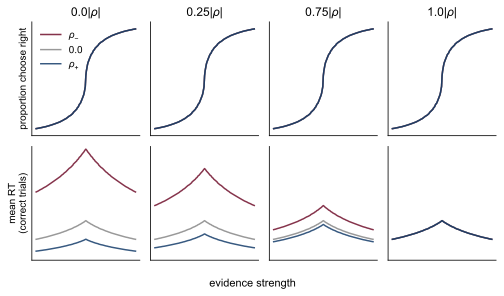

In [19]:
#now print version, predictions only SMOOTH 

fig,ax=plt.subplots(nrows=2,ncols=4,sharex=True)
#then plot best fit model only against data separately per corr cond
for axi,(rcp,dfp_r),(rcc,dfc_r) in zip(ax.T,preds_full_smooth_psycho_ave.groupby('rscale'),
                               preds_full_smooth_chrono_ave.groupby('rscale')):
    assert rcp==rcc
    #print(rcp)
    dfp_r.reset_index(level='rscale',drop=True,inplace=True)
    dfc_r.reset_index(level='rscale',drop=True,inplace=True)
    #display(dfp_r)
    #display(dfc_r)
    plot_psycho_chrono_ave(dfp_r,dfc_r,
                                   alpha=0.8,RT_err=False,ax=axi,ax_labels=False,plot_data=False)
    
    axi[0].set_xlim([-0.01,0.01])
    axi[0].set_ylim((0,1))
    axi[0].set_xticks([])
    ##axi[0].set_yticks([0,0.5,1])
    axi[0].set_yticks([])
    if rcp > 0 and rcp < 1:
        axi[0].set_title(r'%.2f$|\rho|$' % rcp)
    else:
        axi[0].set_title(r'%.1f$|\rho|$' % rcp)
    #axi[0].legend().set_visible(False)
    #axi[1].set_yticks([2,3])
    #axi[1].set_xticks([-1.0,0.0,1.0])
    axi[1].set_xlim([-0.01,0.01])
    axi[1].set_ylim([1,8.])
    axi[1].set_xticks([])
    axi[1].set_yticks([])
    
    axi[1].locator_params(nbins=3, axis='y')
    
    #if rcp > 0:
    axi[0].set_yticklabels([])
    axi[1].set_yticklabels([])
    
    #axi[1].set_ylim((1.75,4))
    ##set_size(6,3,axi[0])
    ##set_size(6,3,axi[1])
    
fig.supxlabel('evidence strength')
ax[0,0].set_ylabel('proportion choose right')
ax[0,0].legend(labels=(r'$\rho_{\minus}$','0.0',r'$\rho_{\plus}$'),
             frameon=False,fontsize=10)
ax[1,0].set_ylabel('mean RT\n(correct trials)')
fig.set_figwidth(18*cm)
fig.set_figheight(21*cm/2)
fig.tight_layout()

fig.savefig(path.join(fig_dir,'fig5_ddm_preds_smooth_vrh_%s.pdf' % date.today()))